# Library import

In [1]:
# 필요 library들을 import합니다.
import os
from typing import Tuple, Any, Callable, List, Optional, Union

import cv2
import timm
import torch
import numpy as np
import pandas as pd
import albumentations as A
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models, datasets, transforms
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from PIL import Image
from functions import *

c:\Users\danyou\anaconda3\envs\boostcamp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Model Training

In [12]:
# 학습에 사용할 장비를 선택.
# torch라이브러리에서 gpu를 인식할 경우, cuda로 설정.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
cd ..

In [13]:
# 학습 데이터의 경로와 정보를 가진 파일의 경로를 설정.
traindata_dir = "./data/train"
traindata_info_file = "./data/train.csv"
save_result_path = "./train_result"

In [14]:
# 학습 데이터의 class, image path, target에 대한 정보가 들어있는 csv파일을 읽기.
train_info = pd.read_csv(traindata_info_file)

# 총 class의 수를 측정.
num_classes = len(train_info['target'].unique())

# 각 class별로 8:2의 비율이 되도록 학습과 검증 데이터를 분리.
train_df, val_df = train_test_split(
    train_info, 
    test_size=0.2,
    stratify=train_info['target']
)

In [15]:
# 학습에 사용할 Transform을 선언.
transform_selector = TransformSelector(
    transform_type = "albumentations"
)
train_transform = transform_selector.get_transform(is_train=True)
val_transform = transform_selector.get_transform(is_train=False)

# 학습에 사용할 Dataset을 선언.
train_dataset = CustomDataset(
    root_dir=traindata_dir,
    info_df=train_df,
    transform=train_transform
)
val_dataset = CustomDataset(
    root_dir=traindata_dir,
    info_df=val_df,
    transform=val_transform
)

# 학습에 사용할 DataLoader를 선언.
train_loader = DataLoader(
    train_dataset, 
    batch_size=64, 
    shuffle=True
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=64, 
    shuffle=False
)

In [16]:
# 학습에 사용할 Model을 선언.
model_selector = ModelSelector(
    model_type='timm', 
    num_classes=num_classes,
    model_name='resnet18', 
    pretrained=True
)
model = model_selector.get_model()

# 선언된 모델을 학습에 사용할 장비로 셋팅.
model.to(device)

TimmModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act1): ReLU(inplace=True)
        (aa): Identity()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

In [17]:
# 학습에 사용할 optimizer를 선언하고, learning rate를 지정
optimizer = optim.Adam(
    model.parameters(), 
    lr=0.001
)

In [18]:
# 스케줄러 초기화
scheduler_step_size = 30  # 매 30step마다 학습률 감소
scheduler_gamma = 0.1  # 학습률을 현재의 10%로 감소

# 한 epoch당 step 수 계산
steps_per_epoch = len(train_loader)

# 2 epoch마다 학습률을 감소시키는 스케줄러 선언
epochs_per_lr_decay = 2
scheduler_step_size = steps_per_epoch * epochs_per_lr_decay

scheduler = optim.lr_scheduler.StepLR(
    optimizer, 
    step_size=scheduler_step_size, 
    gamma=scheduler_gamma
)

In [19]:
# 학습에 사용할 Loss를 선언.
loss_fn = Loss()

In [20]:
# 앞서 선언한 필요 class와 변수들을 조합해, 학습을 진행할 Trainer를 선언. 
trainer = Trainer(
    model=model, 
    device=device, 
    train_loader=train_loader,
    val_loader=val_loader, 
    optimizer=optimizer,
    scheduler=scheduler,
    loss_fn=loss_fn, 
    epochs=100,
    result_path=save_result_path
)

Epoch 1/100


Epoch 1, Train Loss: 4.9056, Train Accuracy: 0.1244
Epoch 1, Validation Loss: 3.1493, Validation Accuracy: 0.3128

Save 0epoch result. Loss = 3.1493
Lowest loss updated to 3.1493. Early stop counter reset to 0.


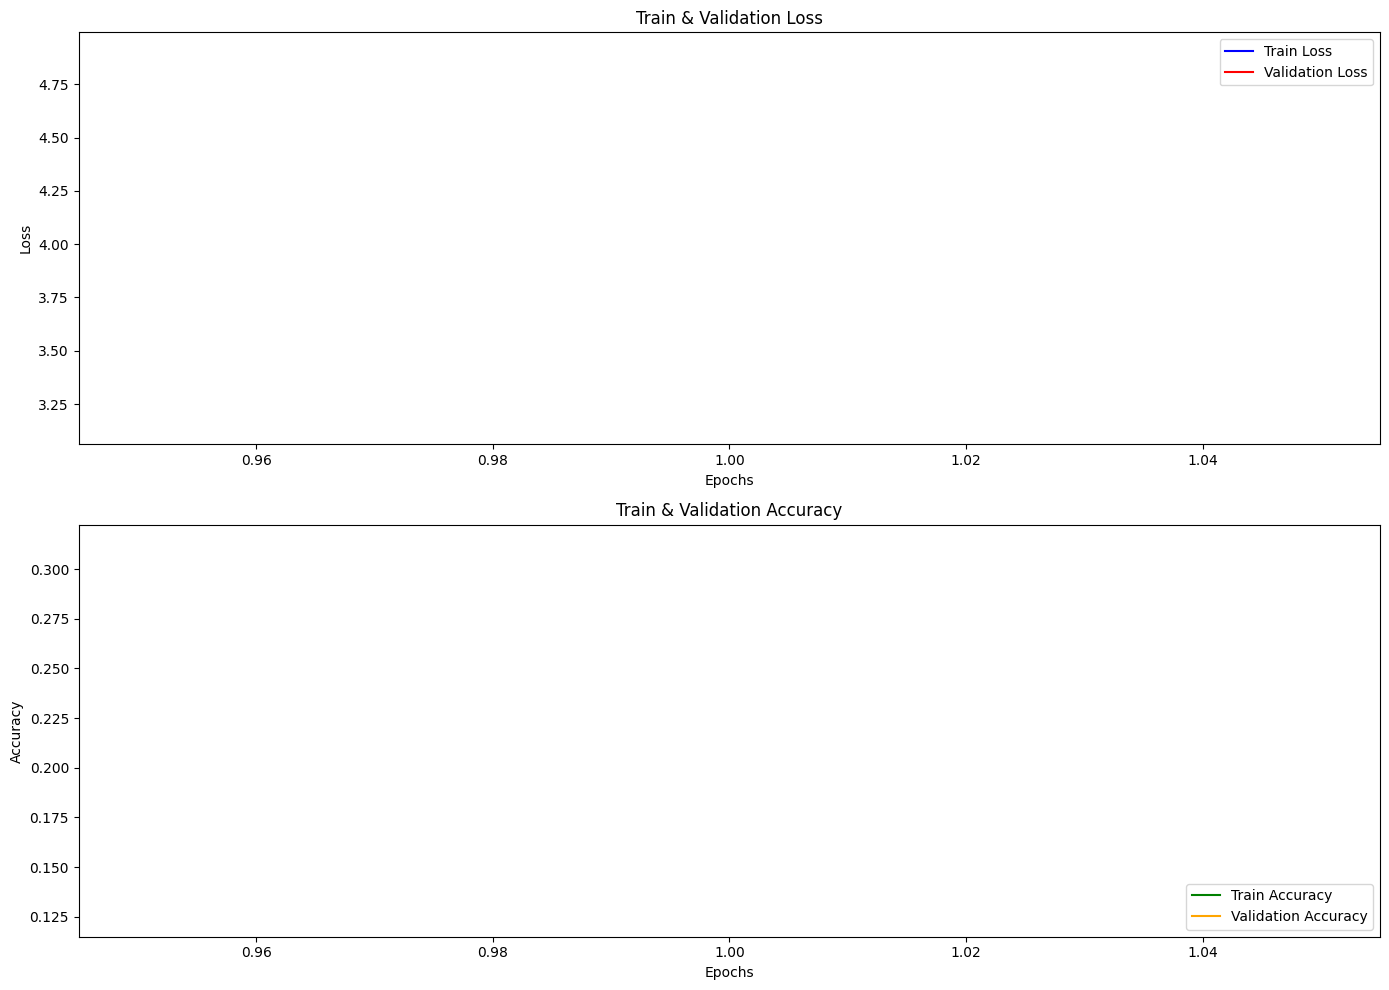

Epoch 2/100


Epoch 2, Train Loss: 2.2826, Train Accuracy: 0.4761
Epoch 2, Validation Loss: 2.0577, Validation Accuracy: 0.4958

Save 1epoch result. Loss = 2.0577
Lowest loss updated to 2.0577. Early stop counter reset to 0.


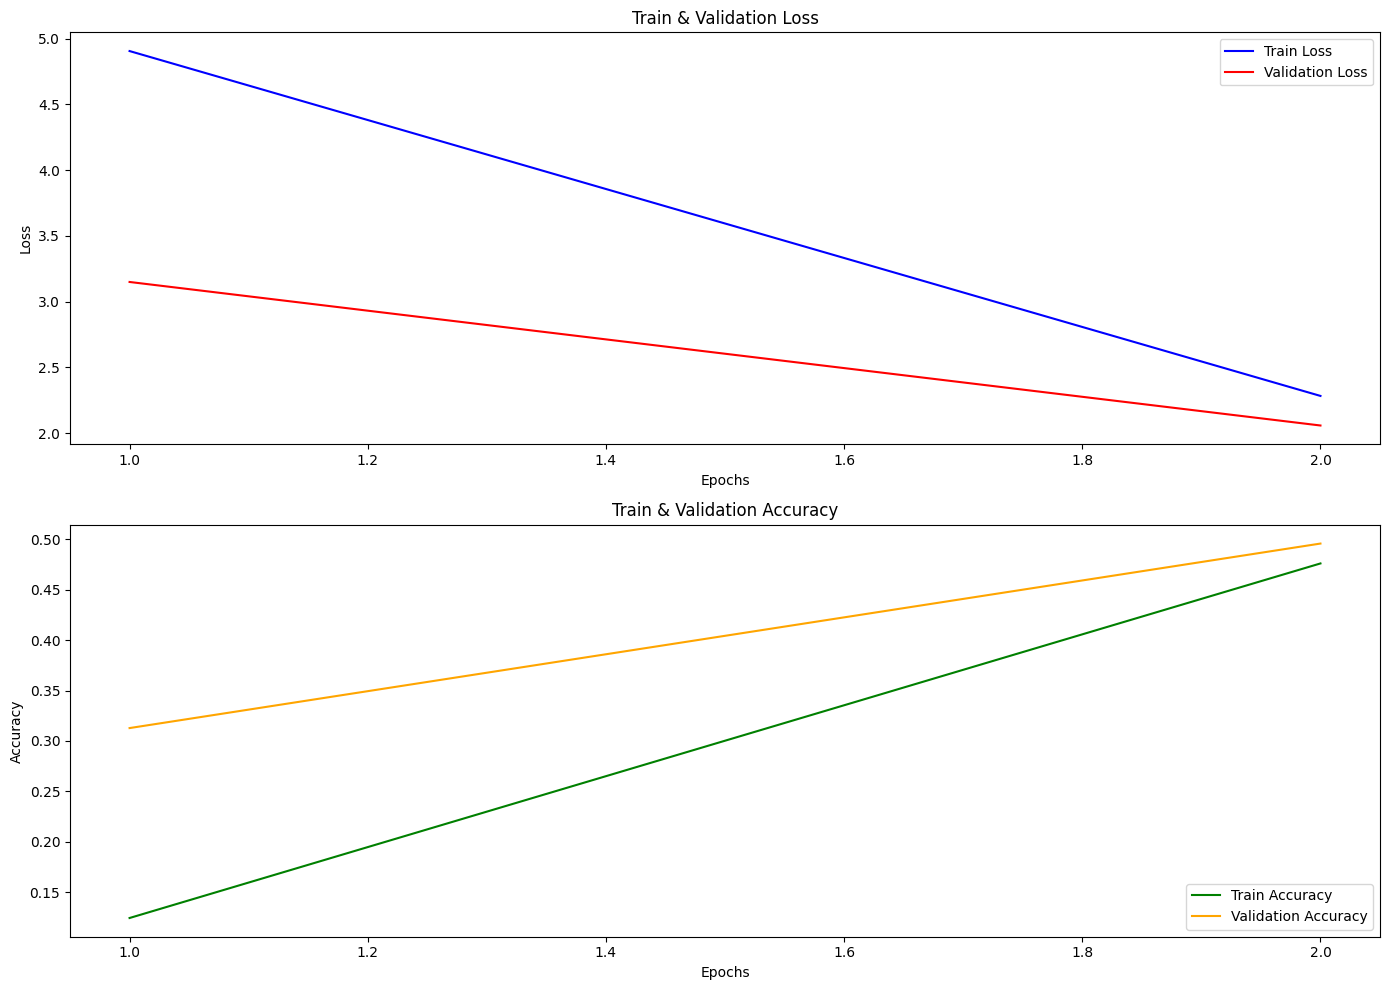

Epoch 3/100


Epoch 3, Train Loss: 1.3914, Train Accuracy: 0.6500
Epoch 3, Validation Loss: 1.5632, Validation Accuracy: 0.5997

Save 2epoch result. Loss = 1.5632
Lowest loss updated to 1.5632. Early stop counter reset to 0.


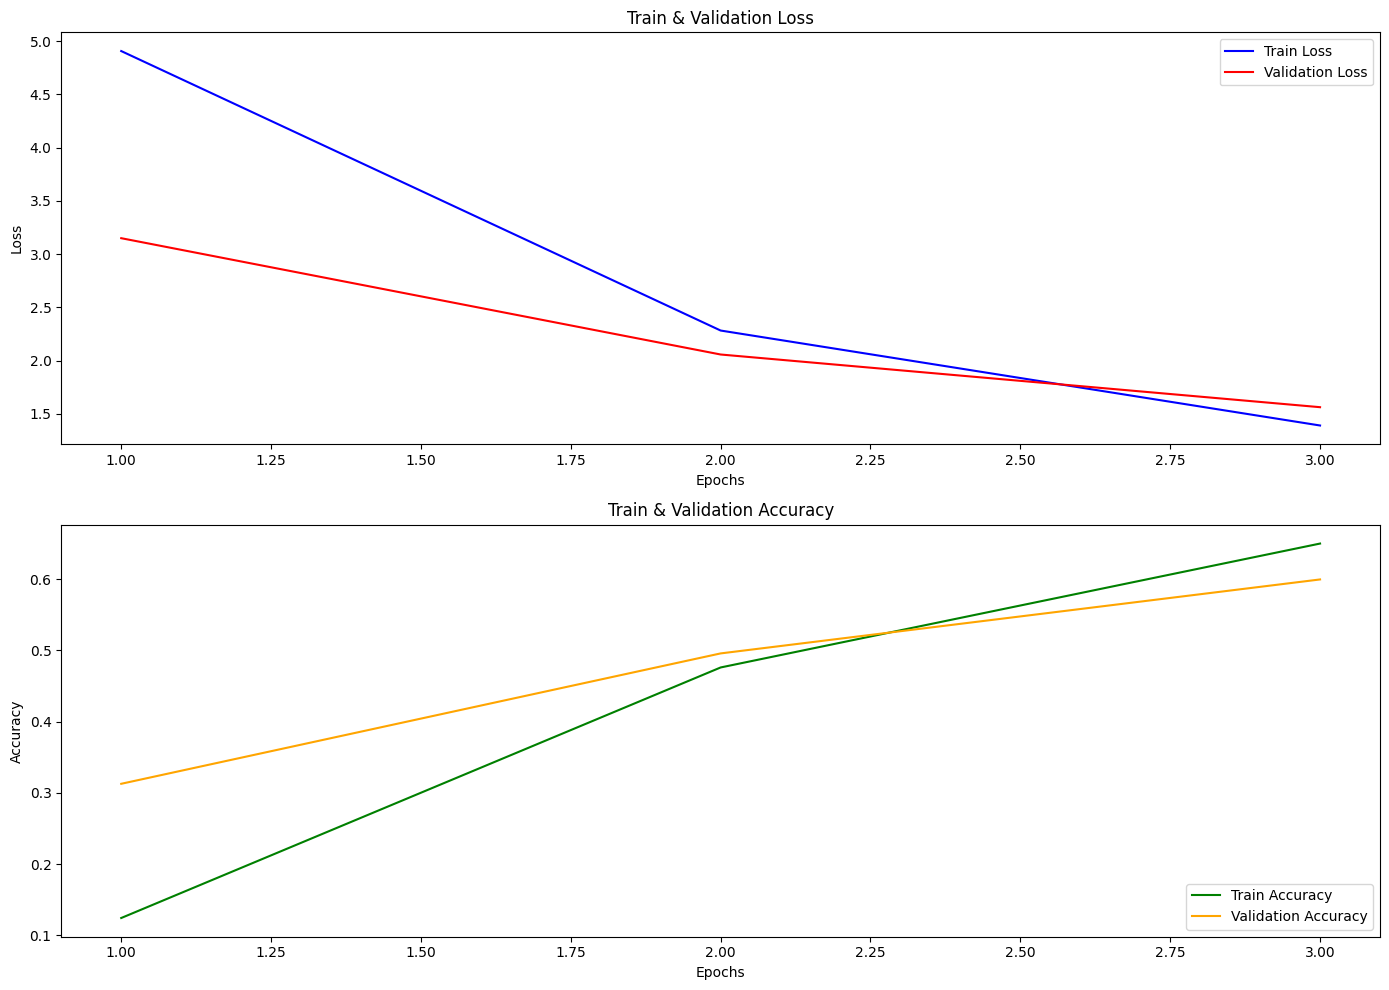

Epoch 4/100


Epoch 4, Train Loss: 0.9436, Train Accuracy: 0.7589
Epoch 4, Validation Loss: 1.4846, Validation Accuracy: 0.6206

Save 3epoch result. Loss = 1.4846
Lowest loss updated to 1.4846. Early stop counter reset to 0.


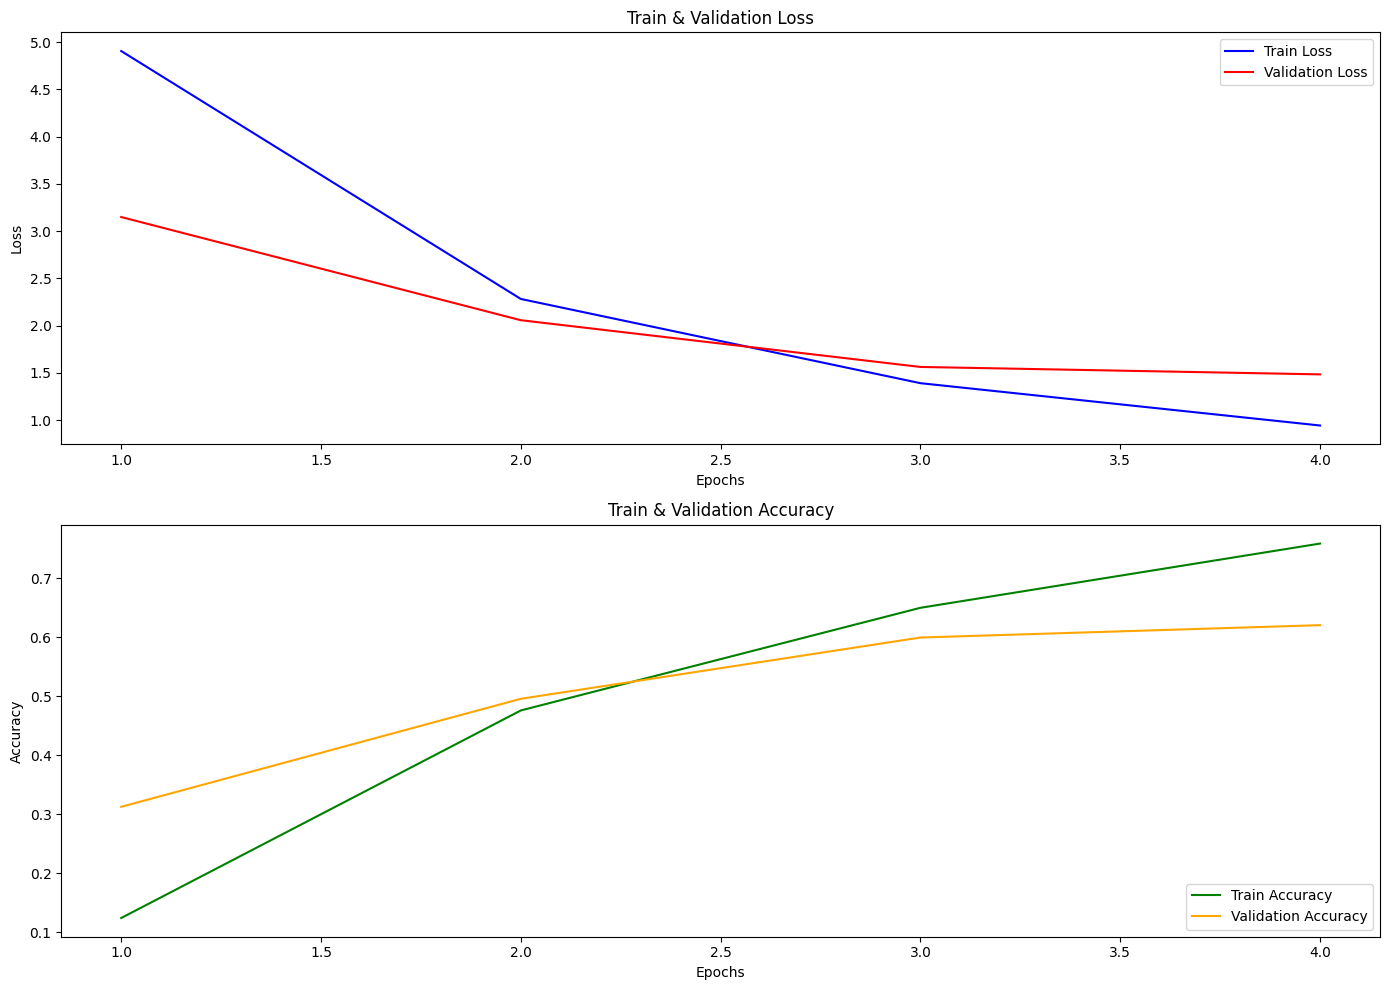

Epoch 5/100


Epoch 5, Train Loss: 0.6969, Train Accuracy: 0.8142
Epoch 5, Validation Loss: 1.3780, Validation Accuracy: 0.6549

Save 4epoch result. Loss = 1.3780
Lowest loss updated to 1.3780. Early stop counter reset to 0.


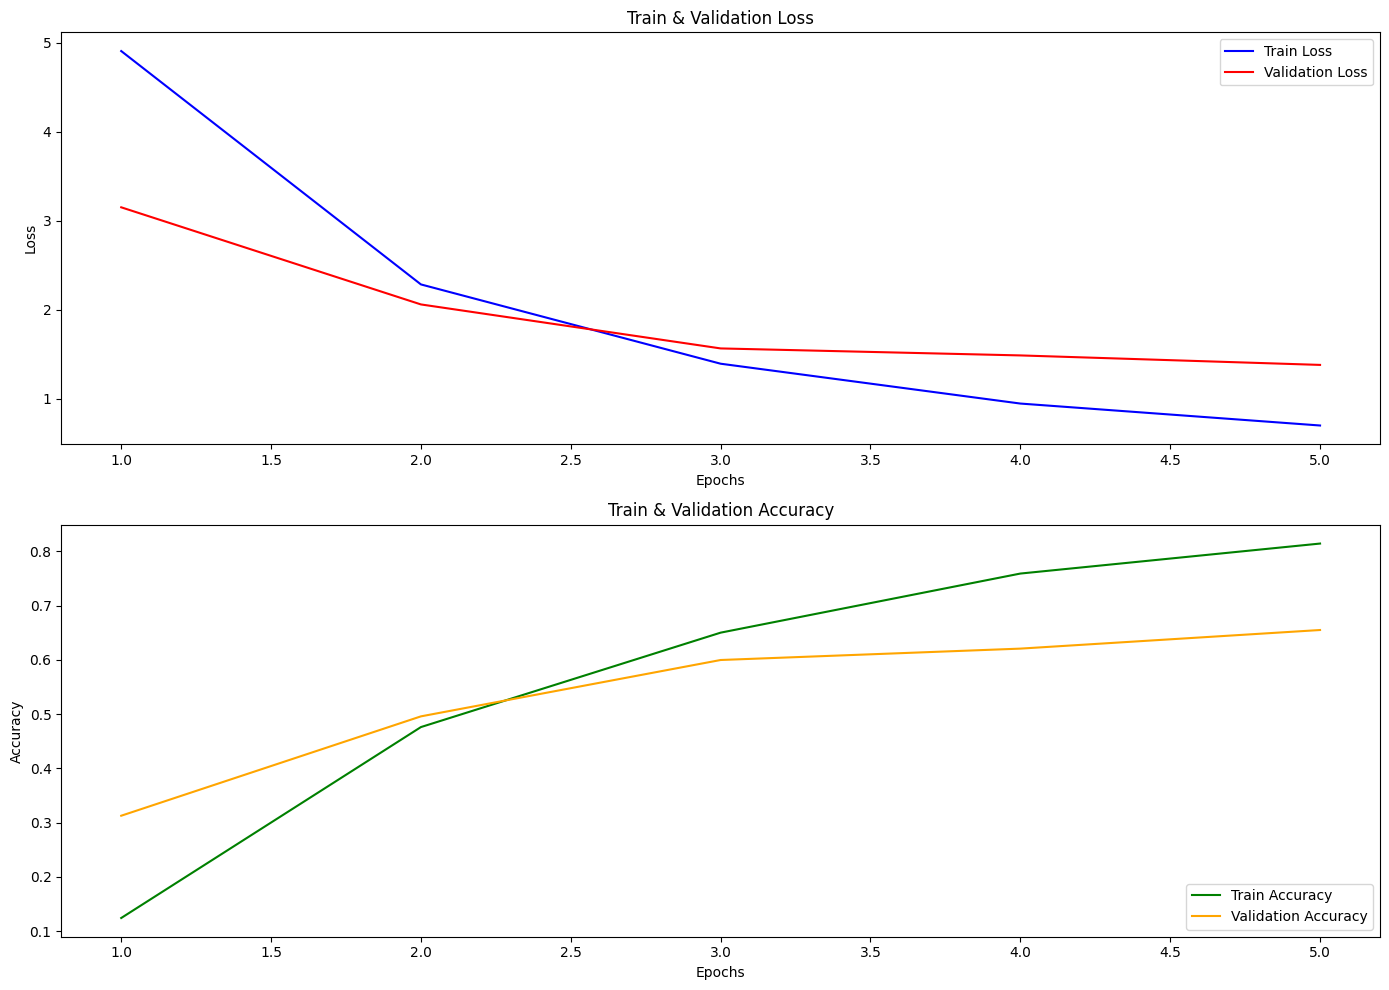

Epoch 6/100


Epoch 6, Train Loss: 0.5138, Train Accuracy: 0.8648
Epoch 6, Validation Loss: 1.3201, Validation Accuracy: 0.6745

Save 5epoch result. Loss = 1.3201
Lowest loss updated to 1.3201. Early stop counter reset to 0.


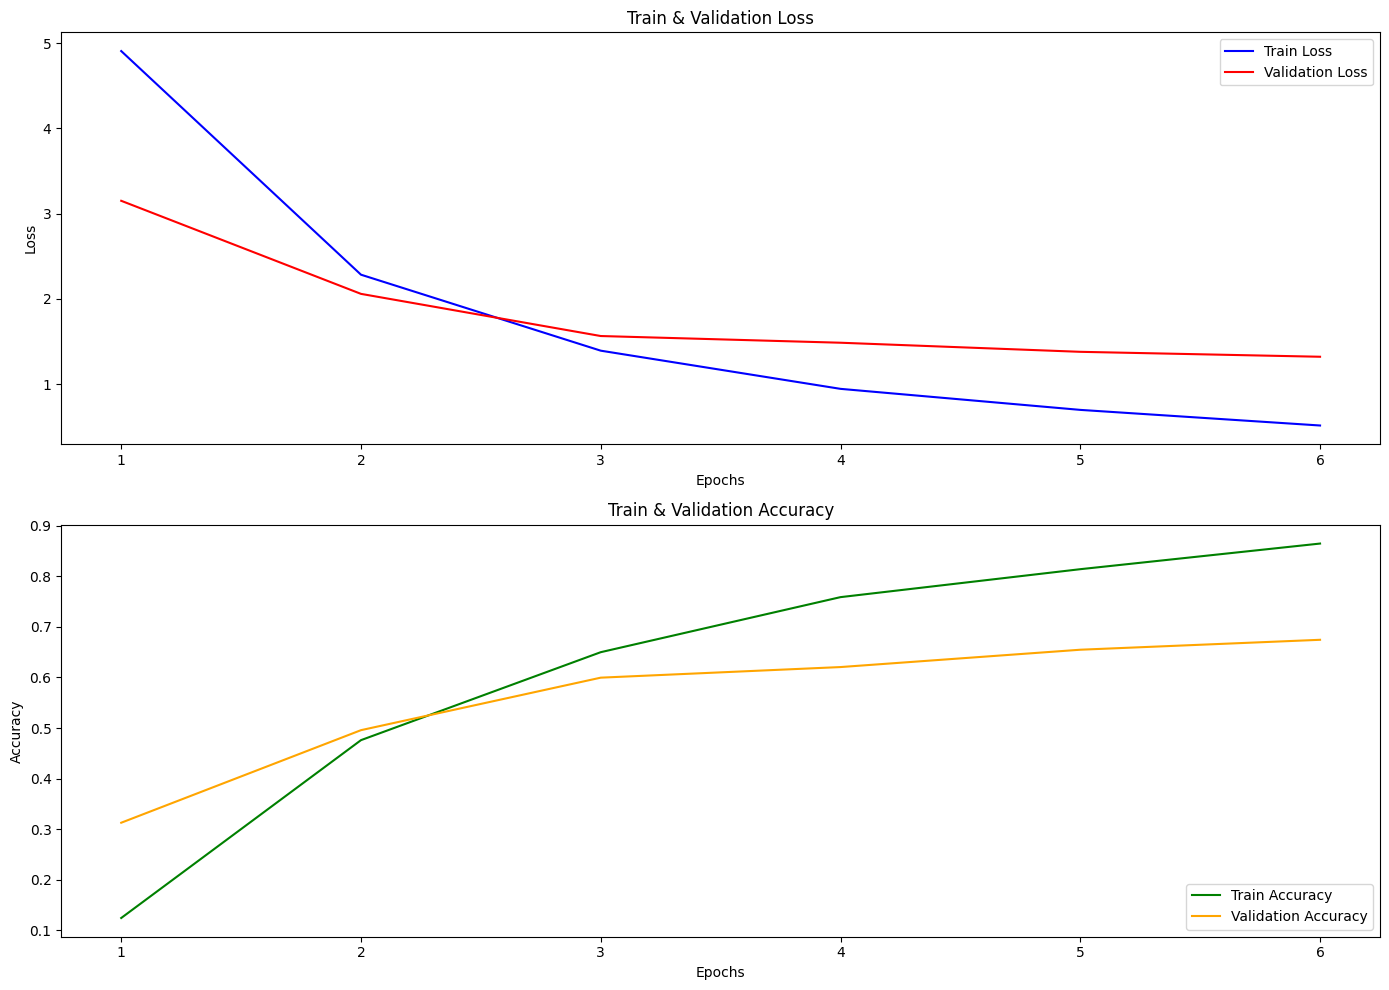

Epoch 7/100


Epoch 7, Train Loss: 0.4011, Train Accuracy: 0.8933
Epoch 7, Validation Loss: 1.2273, Validation Accuracy: 0.6985

Save 6epoch result. Loss = 1.2273
Lowest loss updated to 1.2273. Early stop counter reset to 0.


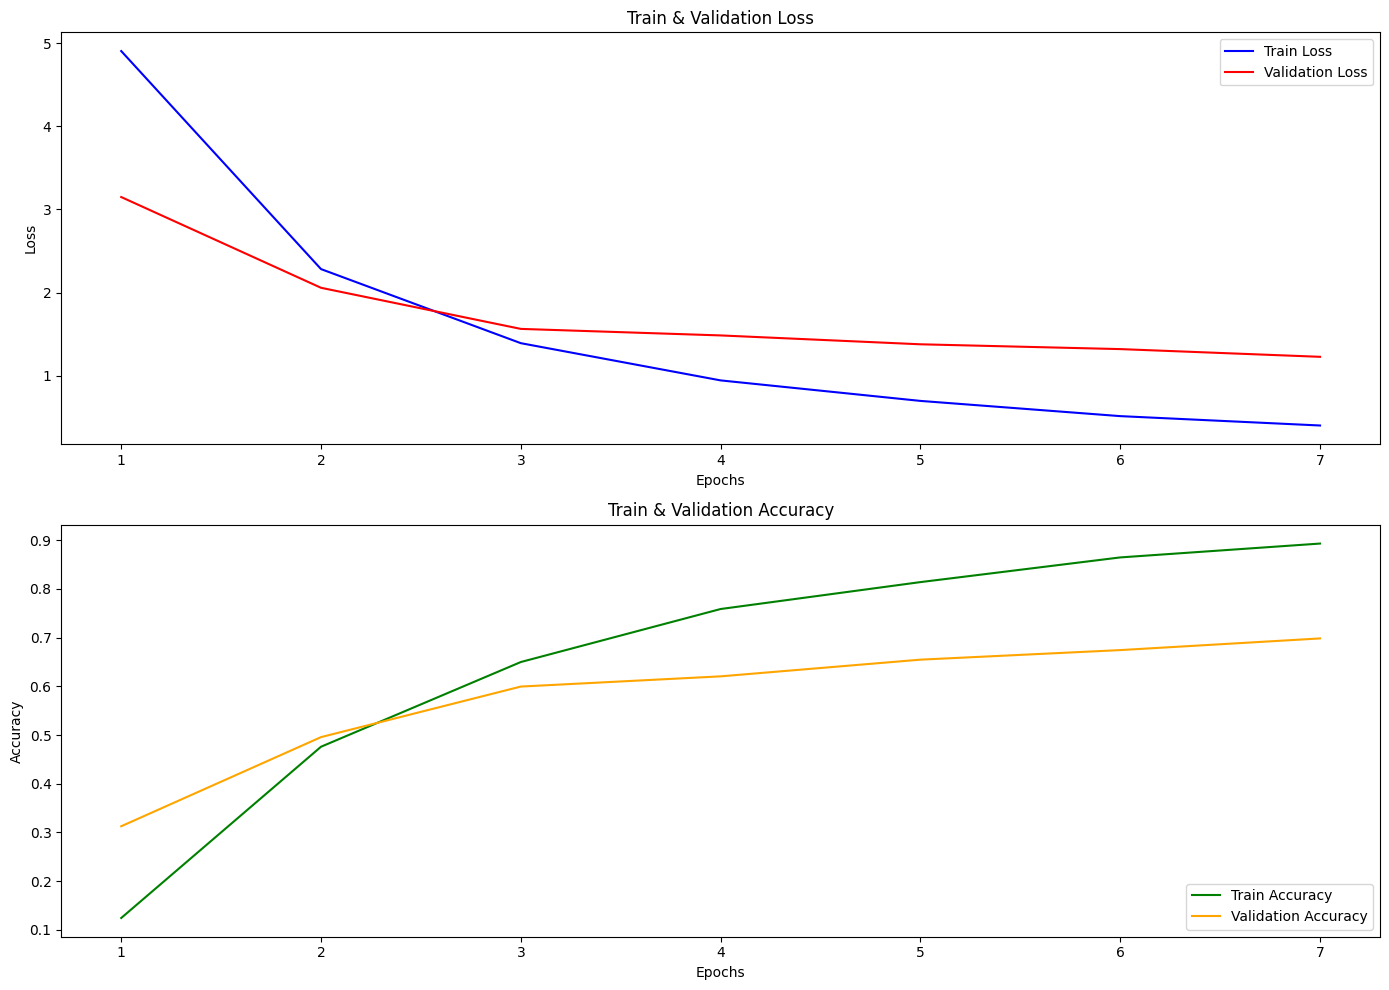

Epoch 8/100


Epoch 8, Train Loss: 0.3145, Train Accuracy: 0.9175
Epoch 8, Validation Loss: 1.3655, Validation Accuracy: 0.6782



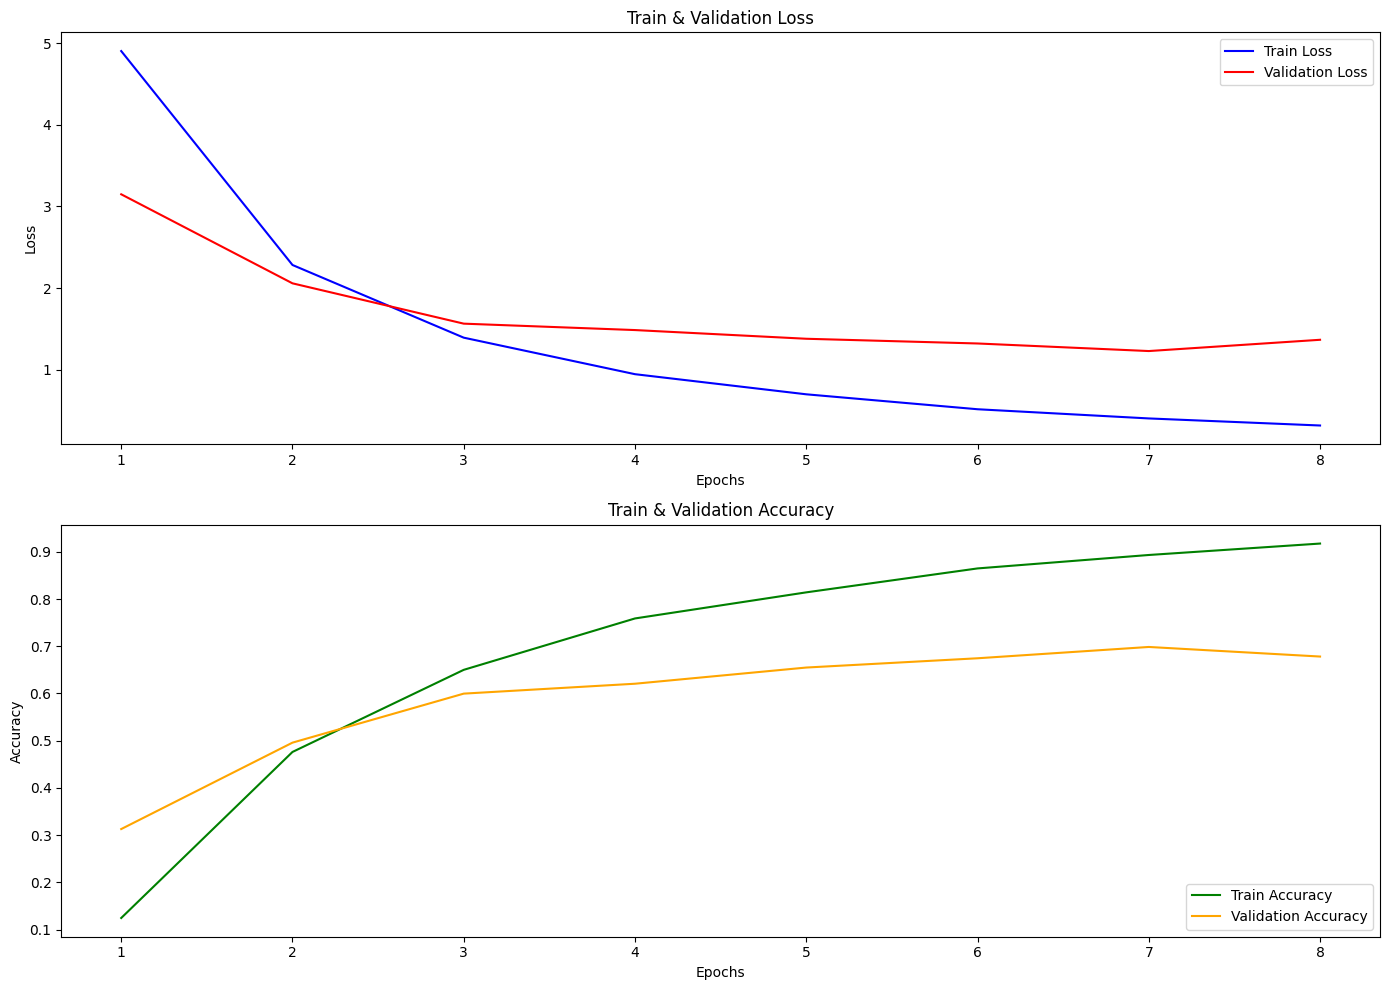

Epoch 9/100


Epoch 9, Train Loss: 0.2644, Train Accuracy: 0.9315
Epoch 9, Validation Loss: 1.2216, Validation Accuracy: 0.7171

Save 8epoch result. Loss = 1.2216
Lowest loss updated to 1.2216. Early stop counter reset to 0.


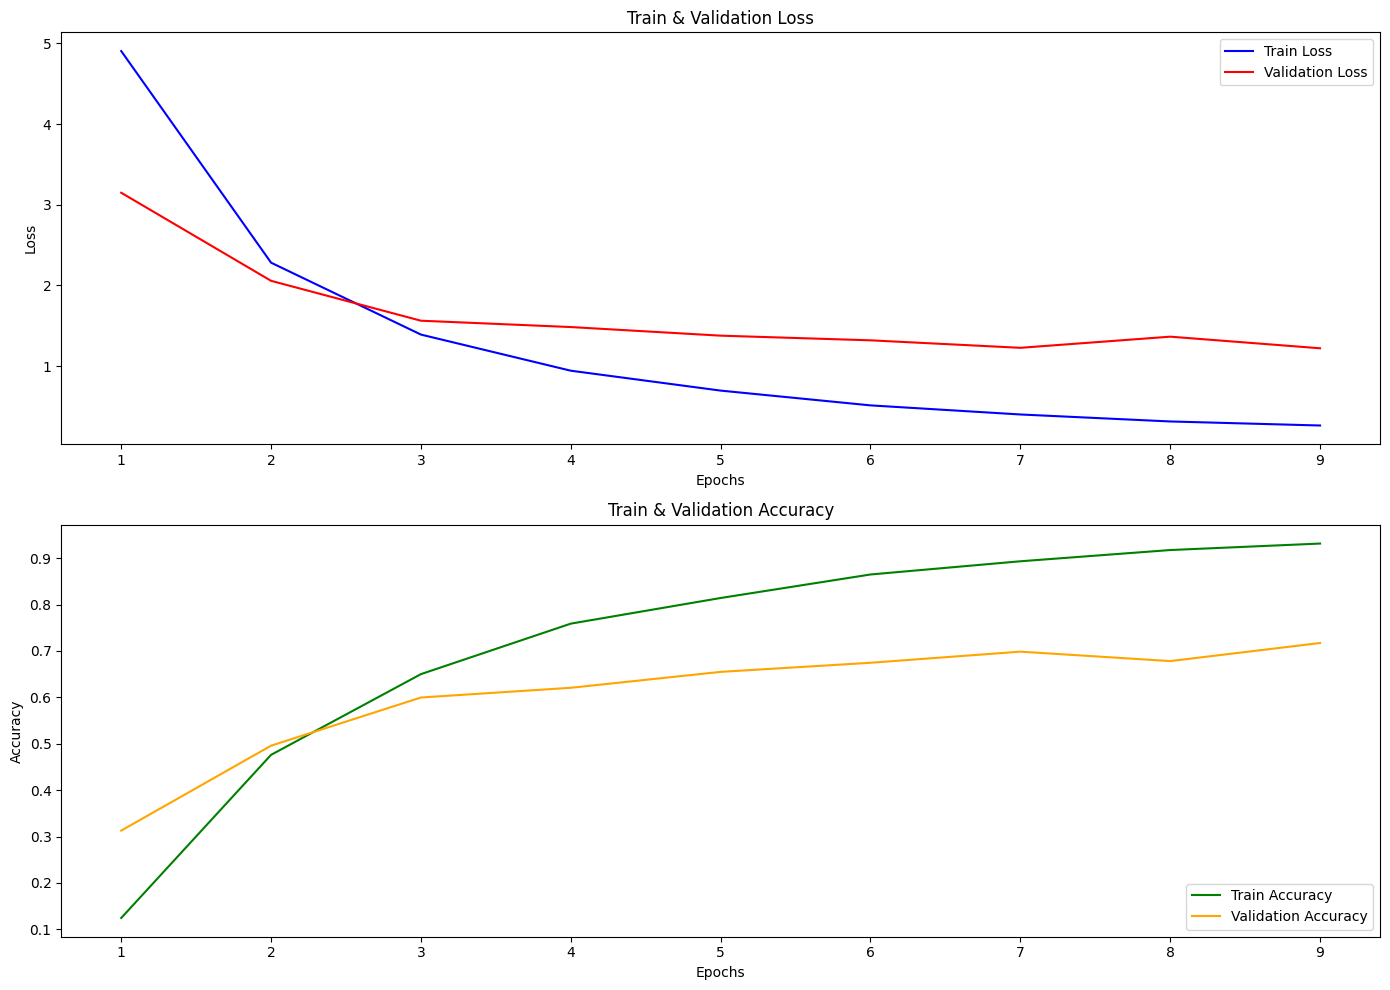

Epoch 10/100


Epoch 10, Train Loss: 0.2306, Train Accuracy: 0.9405
Epoch 10, Validation Loss: 1.2948, Validation Accuracy: 0.7075



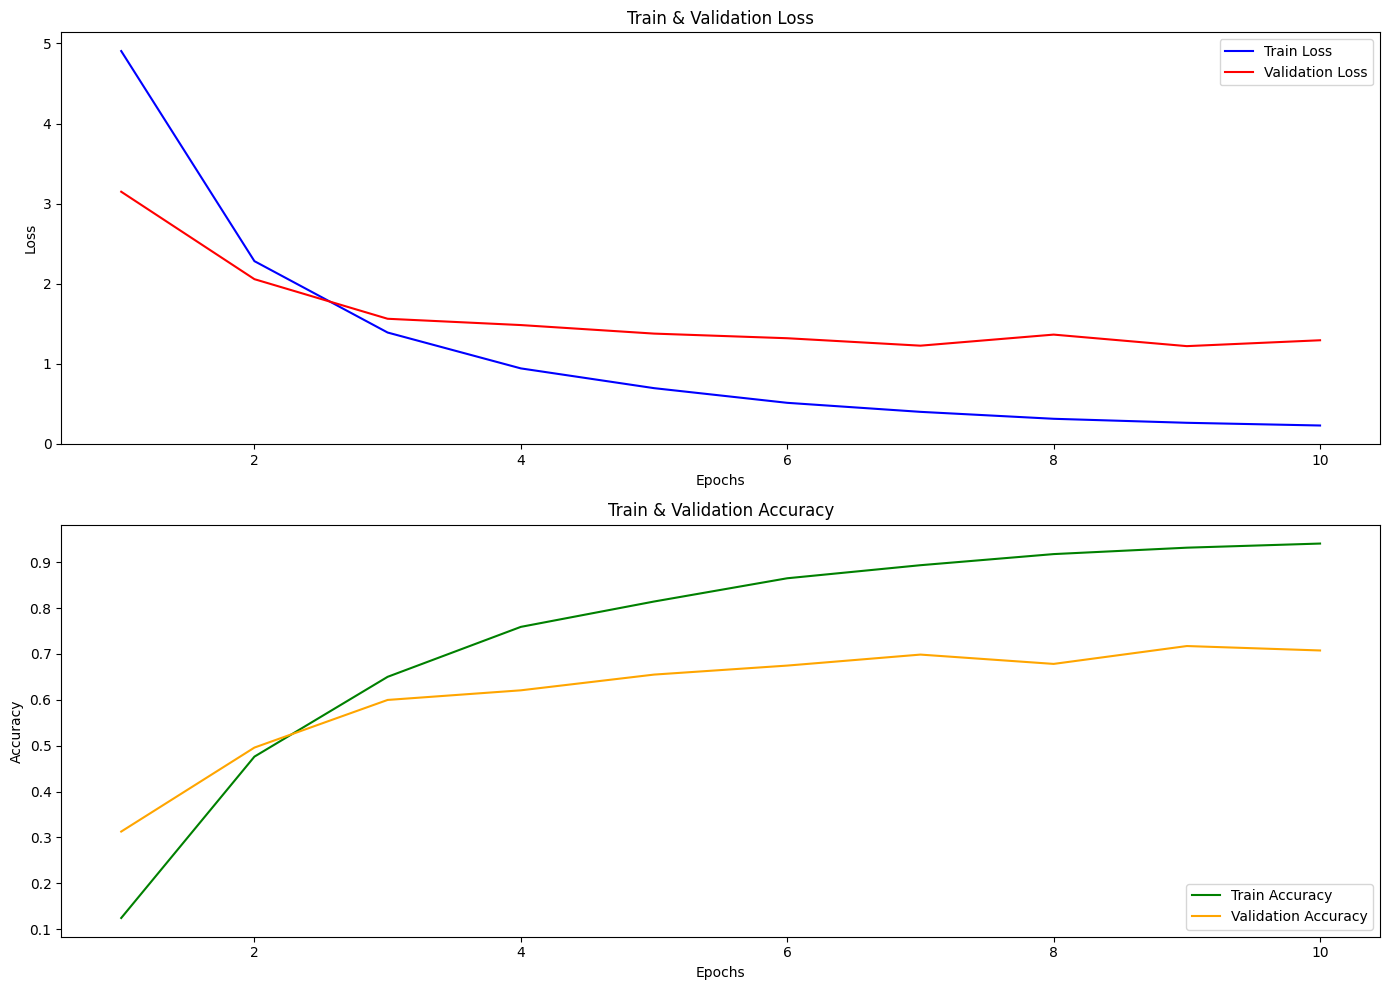

Epoch 11/100


Epoch 11, Train Loss: 0.2158, Train Accuracy: 0.9414
Epoch 11, Validation Loss: 1.2948, Validation Accuracy: 0.7125



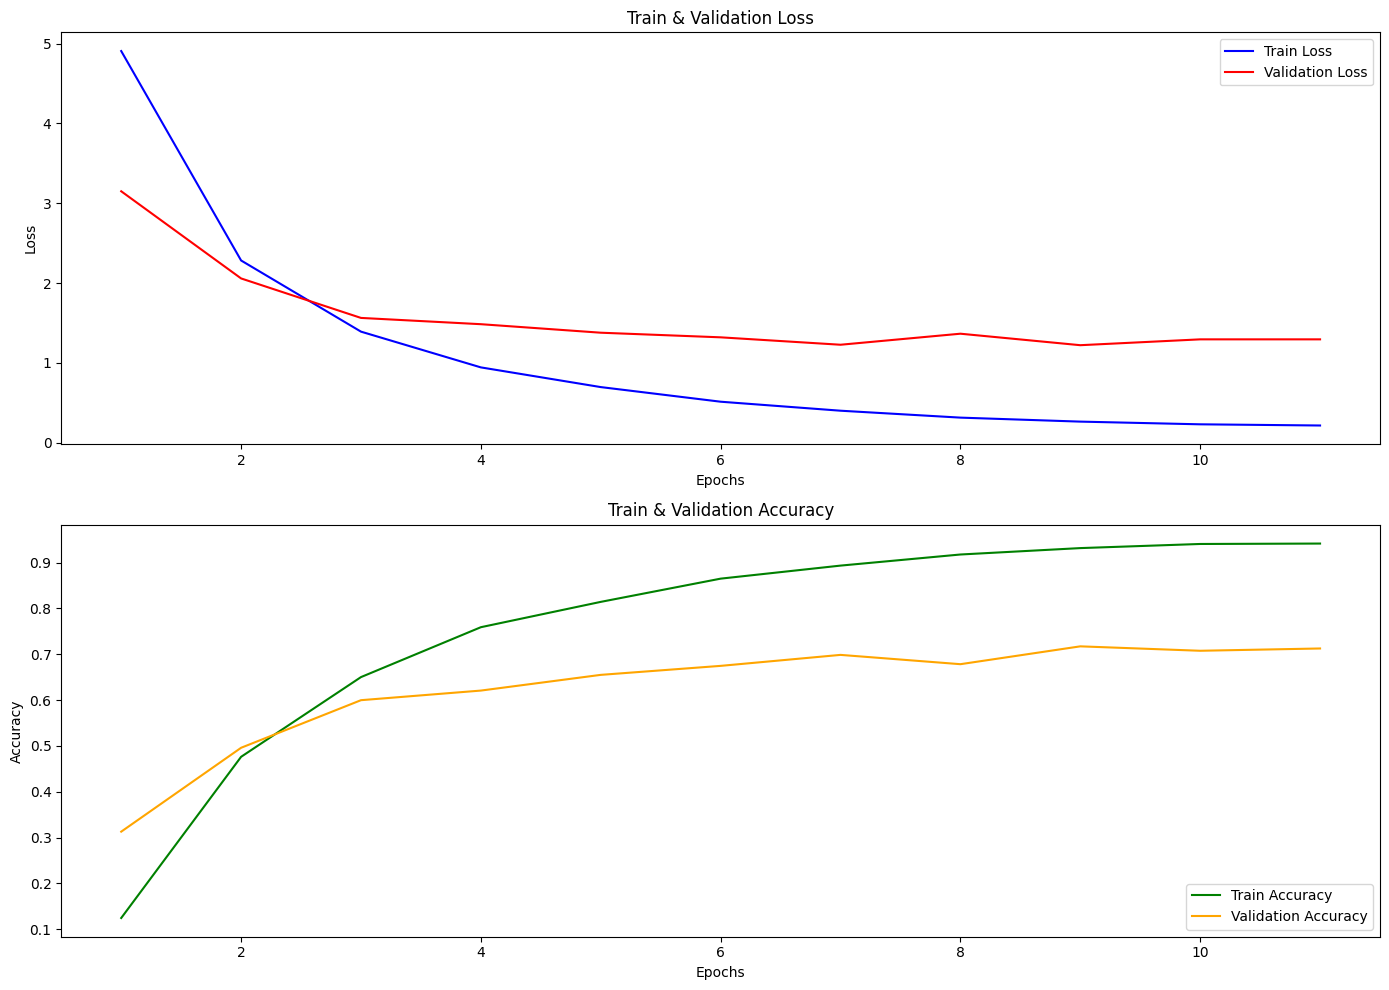

Epoch 12/100


Epoch 12, Train Loss: 0.2027, Train Accuracy: 0.9452
Epoch 12, Validation Loss: 1.2974, Validation Accuracy: 0.6978



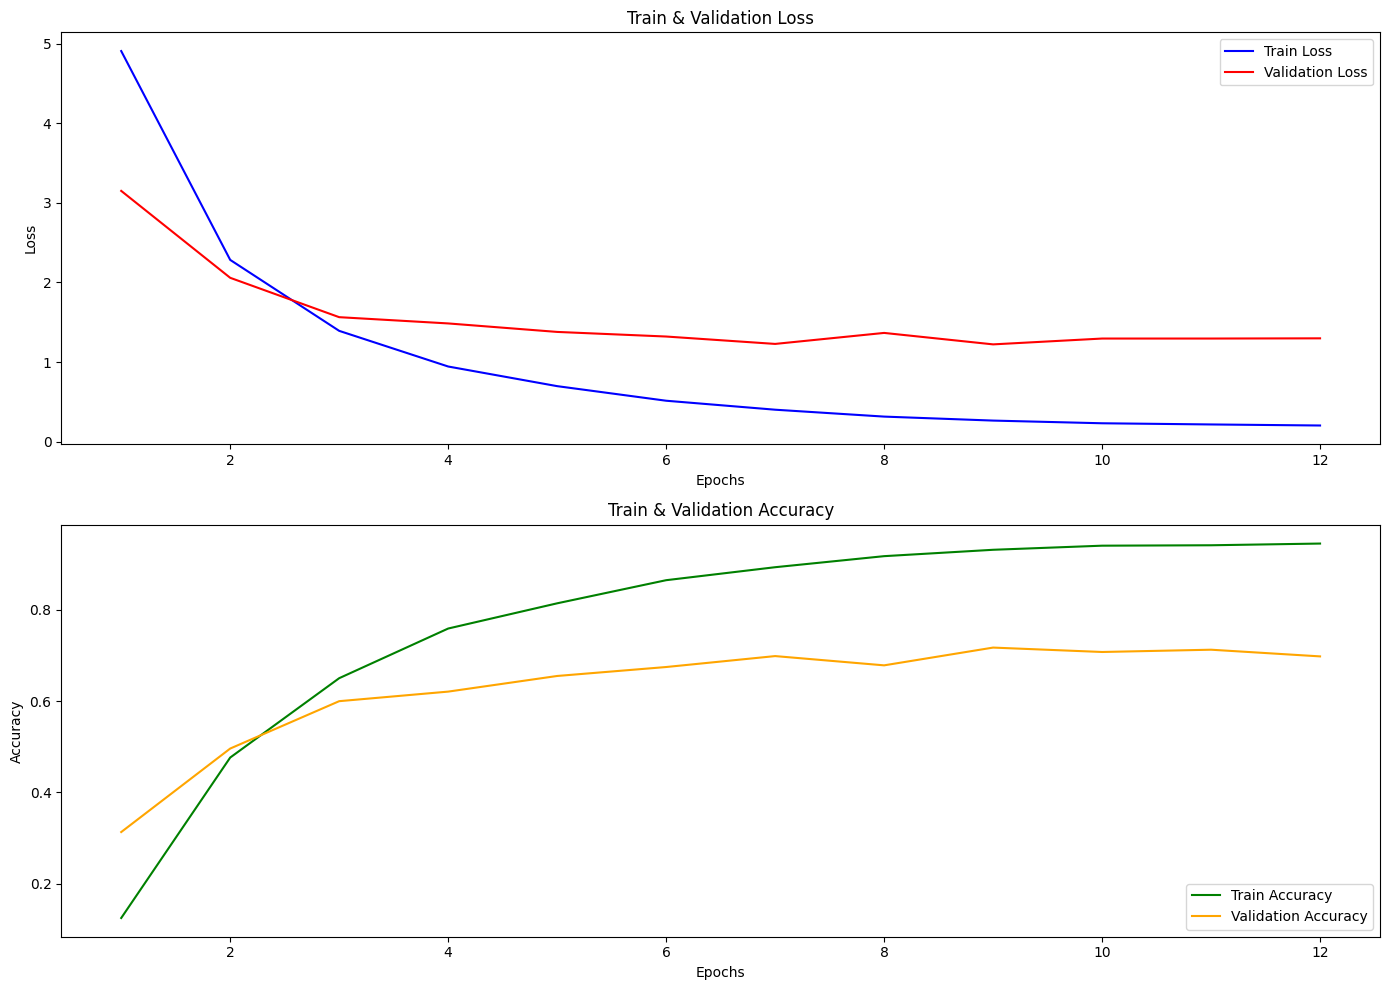

Epoch 13/100


Epoch 13, Train Loss: 0.1697, Train Accuracy: 0.9542
Epoch 13, Validation Loss: 1.3970, Validation Accuracy: 0.6952



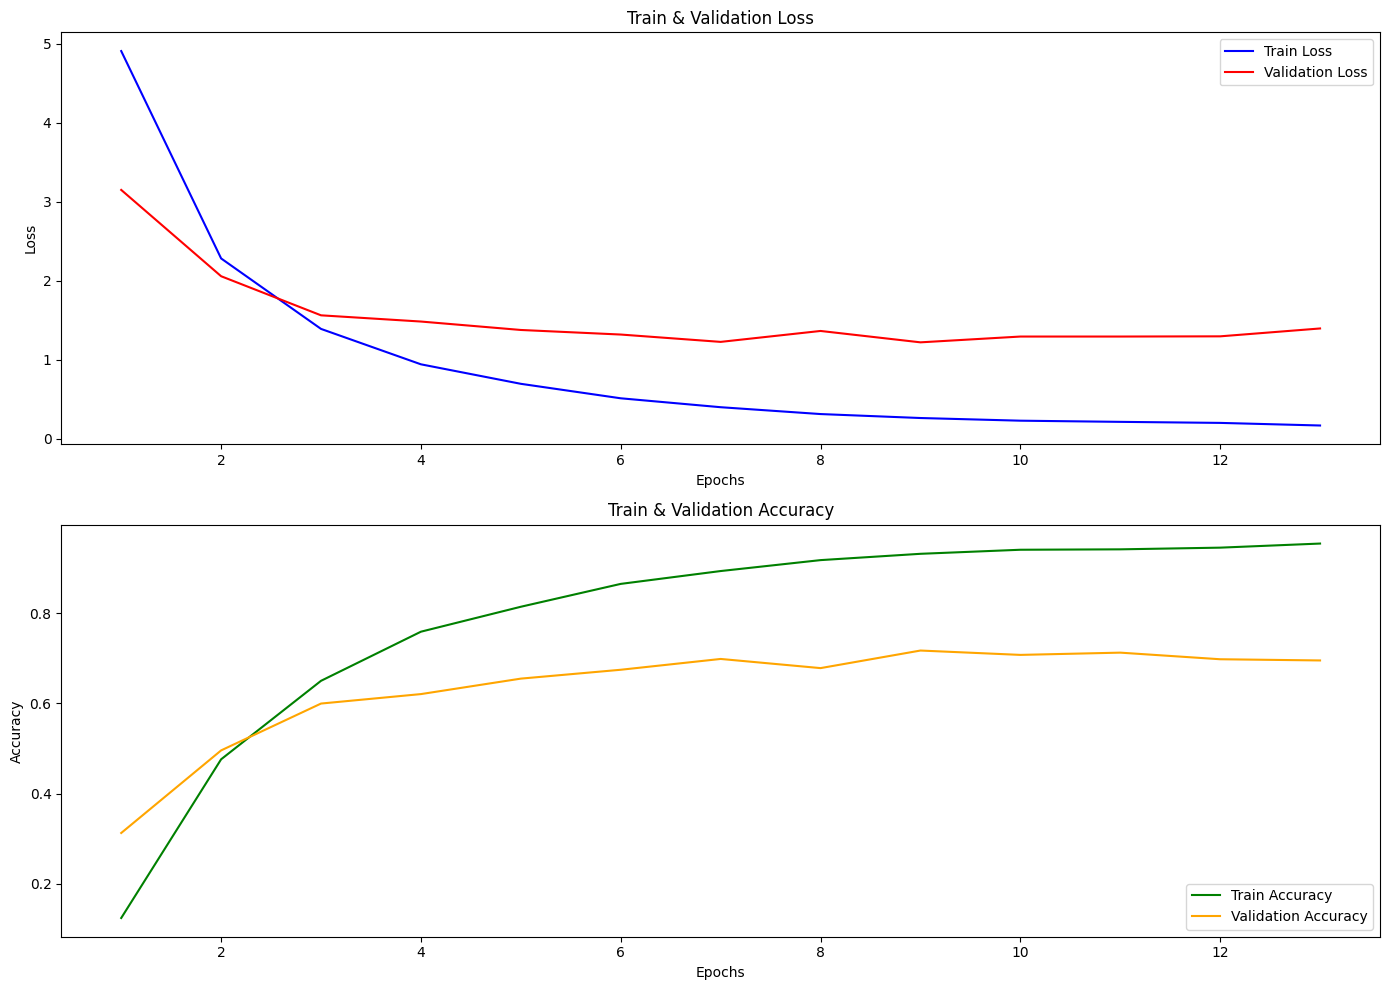

Epoch 14/100


Epoch 14, Train Loss: 0.1674, Train Accuracy: 0.9536
Epoch 14, Validation Loss: 1.4033, Validation Accuracy: 0.7058

Early stopping at epoch 14.


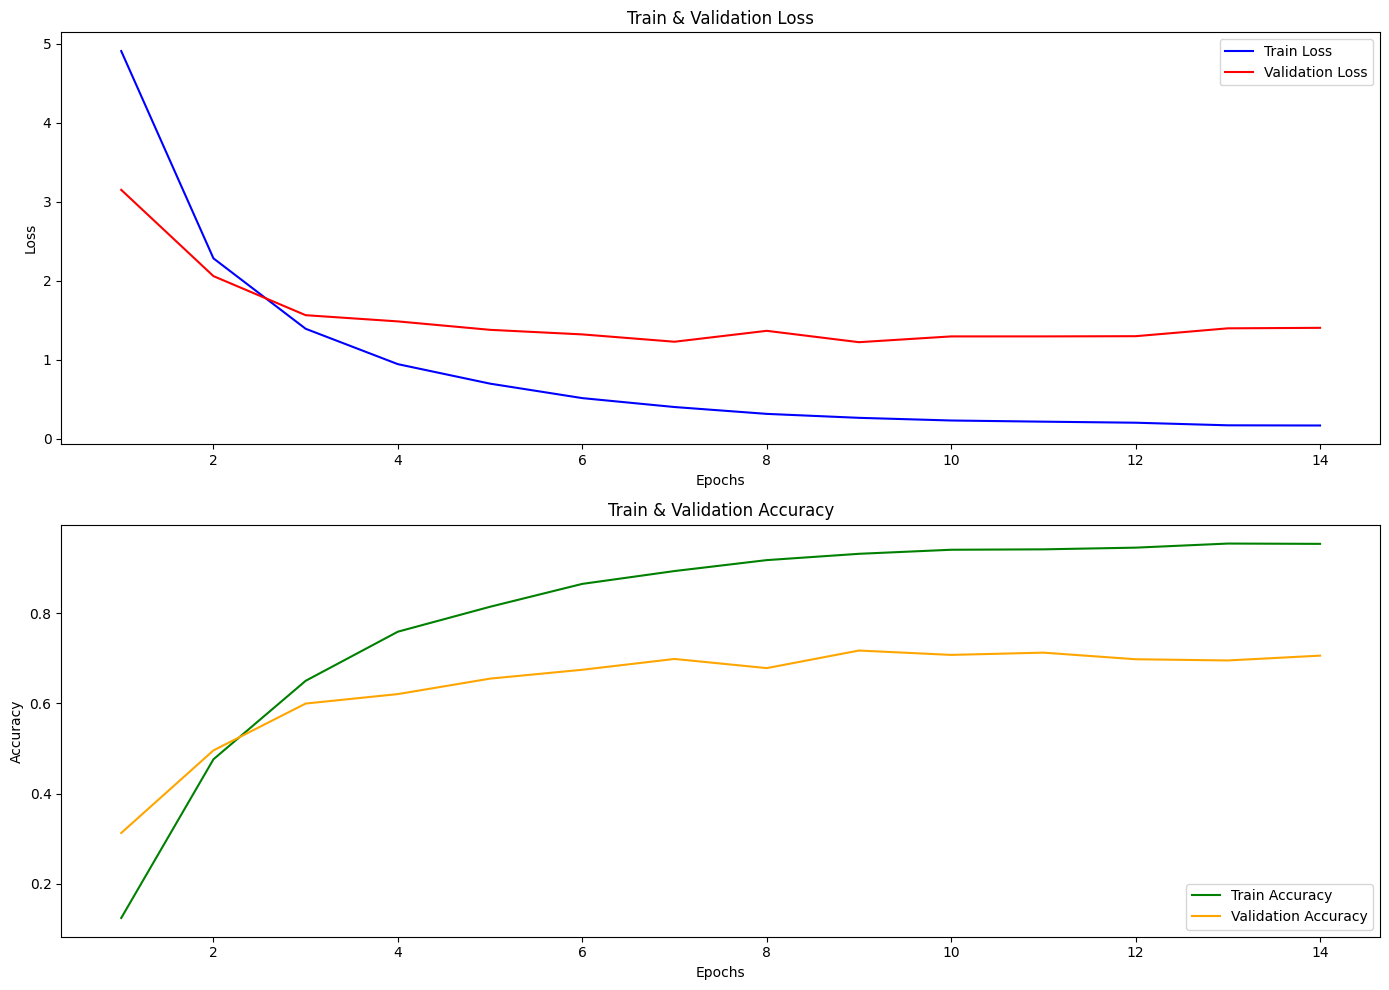

In [21]:
# 모델 학습.
trainer.train()

# Inference

In [31]:
# 모델 추론을 위한 함수
def inference(
    model: nn.Module, 
    device: torch.device, 
    test_loader: DataLoader
):
    # 모델을 평가 모드로 설정
    model.to(device)
    model.eval()
    
    predictions = []
    with torch.no_grad():  # Gradient 계산을 비활성화
        for images in tqdm(test_loader):
            # 데이터를 같은 장치로 이동
            images = images.to(device)
            
            # 모델을 통해 예측 수행
            logits = model(images)
            logits = F.softmax(logits, dim=1)
            preds = logits.argmax(dim=1)
            
            # 예측 결과 저장
            predictions.extend(preds.cpu().detach().numpy())  # 결과를 CPU로 옮기고 리스트에 추가
    
    return predictions

In [32]:
# 추론 데이터의 경로와 정보를 가진 파일의 경로를 설정.
testdata_dir = "./data/test"
testdata_info_file = "./data/test.csv"
save_result_path = "./train_result"

In [33]:
# 추론 데이터의 class, image path, target에 대한 정보가 들어있는 csv파일을 읽기.
test_info = pd.read_csv(testdata_info_file)

# 총 class 수.
num_classes = 500

In [34]:
# 추론에 사용할 Transform을 선언.
transform_selector = TransformSelector(
    transform_type = "albumentations"
)
test_transform = transform_selector.get_transform(is_train=False)

# 추론에 사용할 Dataset을 선언.
test_dataset = CustomDataset(
    root_dir=testdata_dir,
    info_df=test_info,
    transform=test_transform,
    is_inference=True
)

# 추론에 사용할 DataLoader를 선언.
test_loader = DataLoader(
    test_dataset, 
    batch_size=64, 
    shuffle=False,
    drop_last=False
)

In [35]:
# 추론에 사용할 장비를 선택.
# torch라이브러리에서 gpu를 인식할 경우, cuda로 설정.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 추론에 사용할 Model을 선언.
model_selector = ModelSelector(
    model_type='timm', 
    num_classes=num_classes,
    model_name='resnet18', 
    pretrained=False
)
model = model_selector.get_model()


In [36]:
# best epoch 모델을 불러오기.
model.load_state_dict(
    torch.load(
        os.path.join(save_result_path, "best_model.pt"),
        map_location='cpu'
    )
)

C:\Users\danyou\AppData\Local\Temp\ipykernel_35844\1021875342.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(


<All keys matched successfully>

In [37]:
# predictions를 CSV에 저장할 때 형식을 맞춰서 저장
# 테스트 함수 호출
predictions = inference(
    model=model, 
    device=device, 
    test_loader=test_loader
)

100%|██████████| 157/157 [00:42<00:00,  3.68it/s]


In [38]:
# 모든 클래스에 대한 예측 결과를 하나의 문자열로 합침
test_info['target'] = predictions
test_info = test_info.reset_index().rename(columns={"index": "ID"})
test_info

,ID,image_path,target
0,0,0.JPEG,328
1,1,1.JPEG,414
2,2,2.JPEG,418
3,3,3.JPEG,17
4,4,4.JPEG,388
...,...,...,...
10009,10009,10009.JPEG,235
10010,10010,10010.JPEG,111
10011,10011,10011.JPEG,460
10012,10012,10012.JPEG,400


In [39]:
# DataFrame 저장
test_info.to_csv("output.csv", index=False)